In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Library/Mobile Documents/com~apple~CloudDocs/Master/Applied Mathematical Optimization/Project/Git/AMO_Project`


┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API /Users/julia/.julia/scratchspaces/a66863c6-20e8-4ff4-8a62-49f30b1f605e/agent-cache/default-macmini-x64-6.0/build/default-macmini-x64-6-0/julialang/julia-release-1-dot-8/usr/share/julia/stdlib/v1.8/Pkg/src/API.jl:1532


Status `~/Library/Mobile Documents/com~apple~CloudDocs/Master/Applied Mathematical Optimization/Project/Git/AMO_Project/Project.toml`


  [6e4b80f9] BenchmarkTools v1.3.2
  [336ed68f] CSV v0.10.9
  [aaaa29a8] Clustering v0.14.3
  [a9b2a840] Complementarity v0.9.0
⌃ [a93c6f00] DataFrames v1.4.4
  [864edb3b] DataStructures v0.18.13
  [b4f34e82] Distances v0.10.7
  [31c24e10] Distributions v0.25.80
  [5789e2e9] FileIO v1.16.0
⌃ [87dc4568] HiGHS v1.4.1
  [7073ff75] IJulia v1.24.0
  [916415d5] Images v0.25.2
  [b6b21f68] Ipopt v1.1.0
  [c8e1da08] IterTools v1.4.0
⌃ [4076af6c] JuMP v1.6.0
⌃ [b8f27783] MathOptInterface v1.11.4
  [8314cec4] PGFPlotsX v1.5.3
  [f0f68f2c] PlotlyJS v0.18.10
⌃ [91a5bcdd] Plots v1.38.2
⌃ [67491407] Polyhedra v0.7.5
  [f3b207a7] StatsPlots v0.15.4
  [fdbf4ff8] XLSX v0.8.4
  [9a3f8284] Random
  [10745b16] Statistics
Info Packages marked with ⌃ have new versions available and may be upgradable.
Warning The project dependencies or compat requirements have changed since the manifest was last resolved. It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.


In [2]:
# die pakete die wir für dieses Notebook brauchen
using JuMP
using Plots
using XLSX
using DataFrames
using Complementarity
using Ipopt
using Distributions
using CSV
using HiGHS
using StatsPlots

## Robust Optimization with Scenarios
In robust optimization, we do not try to optimize our expected value, but rather we are looking to maximize our worst-case (WC) profits, or reduce WC costs, respectively. For a scenario-based optimization, the resulting mathematical program is very similar to the deterministic equivalent of the stochastic problem:

\begin{align}
\min_{x, y(\omega), \beta} \quad & c^T x + \beta \\             
s.t. \quad &Ax = b \\
& T(\omega) x + W(\omega) y(\omega) = h(\omega) \quad \forall \omega \\
& q(\omega)^T y(\omega) \leq \beta \quad \forall \omega \\              
&x \in X, \; y(\omega) \in Y \; \forall \omega.
\end{align}  

First, we introduce an auxiliary variable $\beta$ which represents the worst-case cost. The new constraint $q(\omega)^T y(\omega) \leq \beta$ ensures that, $\forall \omega$, $\beta$ is at least as big as the cost in the scenario. Assuming strictly different **wait-end-see** cost (second stage), that constraint will be binding on the WC scenario and not binding elsewhere. We thus include the WC cost of our second stage to the objective. Note that, now, we do not need $\pi(\omega)$ anymore: Our conservativeness relieves us of the necessity to define probability distributions for certain events. On the downside, our formulation is very sensitive to extreme events. 

In [3]:
# read in the generated scenarios (see ScenarioGen+Red.ipynb for details)
scenarios = []
for i in 1:43
    push!(scenarios,CSV.read("./data/scenarios_new/scenarios_hour$i.csv",DataFrame))
end
scenarios[1][2,:]
# read in the probabilities for the scenarios
probabilities = CSV.read("./data/scenarios_new/probabilities.csv", DataFrame)

println(scenarios[1])
println(probabilities)

4×5 DataFrame
 Row │ Column1   Column2   Column3   Column4   Column5  
     │ Float64   Float64   Float64   Float64   Float64  
─────┼──────────────────────────────────────────────────
   1 │ 113.47    145.96    144.499   146.994   150.768
   2 │ 136.973   137.162   139.765   104.068   146.868
   3 │  54.8948   39.8038   54.1716   54.882    58.7665
   4 │  42.9557   43.8939   33.6926   42.6606   44.8779
43×5 DataFrame
 Row │ Scen1    Scen2    Scen3    Scen4    Scen5   
     │ Float64  Float64  Float64  Float64  Float64 
─────┼─────────────────────────────────────────────
   1 │  0.1796   0.1976   0.1914   0.1706   0.2608
   2 │  0.185    0.1776   0.1948   0.2672   0.1754
   3 │  0.1886   0.1782   0.2864   0.1636   0.1832
   4 │  0.1686   0.18     0.1666   0.2984   0.1864
   5 │  0.1658   0.2888   0.1796   0.1938   0.172
   6 │  0.1822   0.314    0.1706   0.1578   0.1754
   7 │  0.1772   0.167    0.3022   0.1758   0.1778
   8 │  0.3038   0.1718   0.1678   0.1718   0.1848
   9 │  0.1894 

In [4]:
#Transform scenario data (to able get value by windata[hour][zone][scenario])
wind_data =  [[[scenarios[h][w,s] for s in 1:5] for w in 1:4] for h in 1:43]
prob_data =  [[probabilities[h,s] for s in 1:5] for h in 1:43]
println(wind_data[12][2][1]) # value for scenario 1 of zone 2 at hour 12
println(prob_data[12][1]) # probability for scenario 1 at hour 12

172.91544928425168
0.176


In [5]:
wind_data[1]

4-element Vector{Vector{Float64}}:
 [113.47039204738206, 145.9599481671129, 144.49895772528257, 146.99387108449213, 150.76755977445586]
 [136.97310435196584, 137.1621112047185, 139.76460455154148, 104.06849121362949, 146.86795254949104]
 [54.89479301155139, 39.803776641645, 54.1715638484036, 54.88199134796284, 58.76649486045867]
 [42.95574247684342, 43.89392371520295, 33.69258312822886, 42.660641137559466, 44.87793357049182]

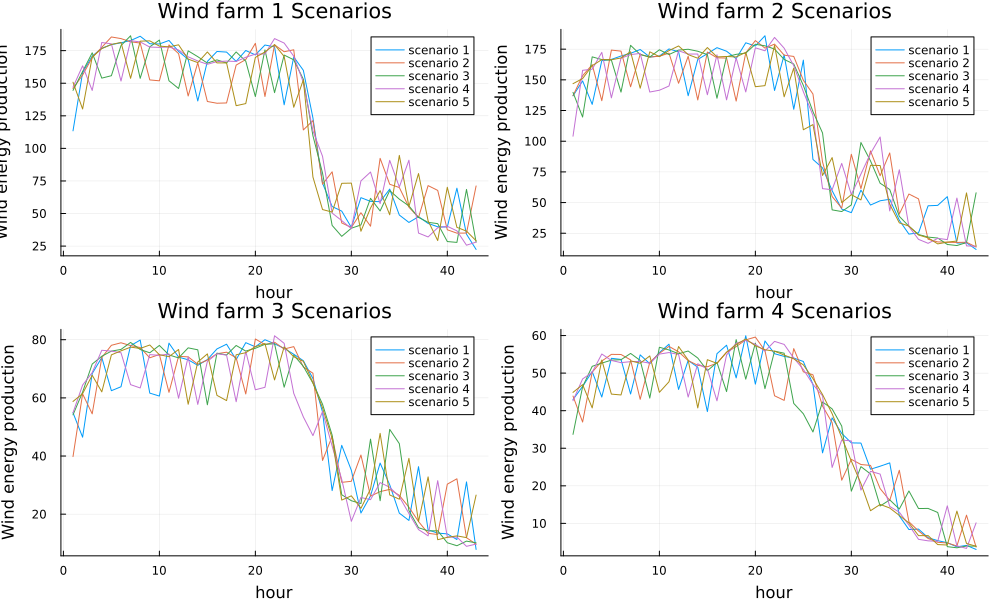

In [6]:
# look at scenario values
function get_plot(i,df)
    a = plot(collect(1:43),[df[k][i,1] for k in 1:43] ,label = "scenario 1", xlabel = "hour", ylabel = "Wind energy production", title = "Wind farm " * string(i) * " Scenarios")
    plot!(collect(1:43),[df[k][i,2] for k in 1:43] ,label = "scenario 2", xlabel = "hour", ylabel = "Wind energy production")
    plot!(collect(1:43),[df[k][i,3] for k in 1:43] ,label = "scenario 3", xlabel = "hour", ylabel = "Wind energy production")
    plot!(collect(1:43),[df[k][i,4] for k in 1:43] ,label = "scenario 4", xlabel = "hour", ylabel = "Wind energy production")
    plot!(collect(1:43),[df[k][i,5] for k in 1:43] ,label = "scenario 5", xlabel = "hour", ylabel = "Wind energy production")

    return a
end
plot(get_plot(1,scenarios),get_plot(2,scenarios),get_plot(3,scenarios),get_plot(4,scenarios),layout = (2,2),size = (1000,600))

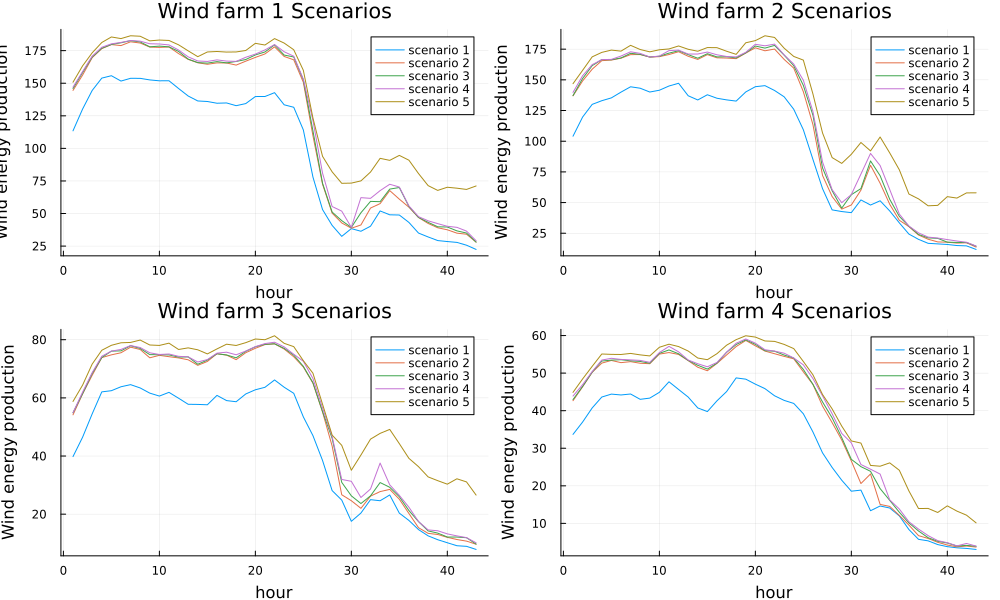

In [7]:
# Sort scenarios for better visibility (This is possible since scenarios across different hours are completly independent, meaning the scenario index across hours is meaningless)
sorted_scenarios = deepcopy(scenarios)
for k in 1:43, i in 1:4
    sorted_scenarios[k][i,:] = sort!(Array(sorted_scenarios[k][i,:]))
end
plot(get_plot(1,sorted_scenarios),get_plot(2,sorted_scenarios),get_plot(3,sorted_scenarios),get_plot(4,sorted_scenarios),layout = (2,2),size = (1000,600))

In [8]:
wind_data[1][1][1]

113.47039204738206

In [42]:
function solveModel(t::Int,data)
    m = Model(HiGHS.Optimizer)
    @variable(m, 0 <= PG[k in data[:K]] <= data[:Pmax][k]) # Power output of Generators
    @variable(m, 0 <= PW[w in data[:W]] <= data[:Wmax][w]) # schdeuled Power output of Windfarm --> max is capacity
    @variable(m, 0 <= Ru[k in data[:K]] <= data[:Rmax][k]) # Upward schelduled Reserve for each Generator
    @variable(m, 0 <= Rd[k in data[:K]] <= data[:Rmax][k]) # Downward scheduled Reserve for each Generator
    @variable(m, 0 <= Wspill[s in data[:S]] <= sum(data[:wind][t][w][s] for w in data[:W])) # Wind spillage for each scenario(no cost)
    @variable(m, 0 <= Lshed[s in data[:S]] <= sum(data[:D])) # Load shedding for each scenario
    @variable(m, 0 <= ru[k in data[:K],s in data[:S]]) #upward balancing for each scenario
    @variable(m, 0 <= rd[k in data[:K],s in data[:S]]) #downward balancing for each scenario
    @variable(m, 0 <= β) #worst case scenario

    @constraint(m,λ, sum(PG) + sum(PW) - sum(data[:D]) == 0) # balancing energy in day-ahead
    @constraint(m,Puu[k in data[:K], s in data[:S]], ru[k,s] <= Ru[k]) #  upward reserve dispatched cant be larger than allocated upward reserve
    @constraint(m,Pdu[k in data[:K], s in data[:S]], rd[k,s] <= Rd[k]) # downward reserve dispatched cant be larger than allocated downward reserve
    for s in data[:S]
        @constraint(m, sum(ru[k,s] - rd[k,s] for k in data[:K]) + Lshed[s] + sum(data[:wind][t][w][s] for w in data[:W]) - sum(PW) - Wspill[s] == 0) # balancing energy in real-time scenarios
    end
    @constraint(m, uRmax[k in data[:K]], PG[k] + Ru[k] <= data[:Pmax][k]) # Upward reserve + Poweroutput <= Ma  x Capacity
    @constraint(m, dRmax[k in data[:K]], PG[k] - Rd[k] >= 0) # Poweroutput - Downward reserve >= 0
        
    @expression(m,Cexp,sum(data[:prob][t][s] * ((sum(data[:C][k] * (ru[k,s] - rd[k,s]) for k in data[:K]) + data[:vLOL]*Lshed[s])) for s in data[:S])) # ERD expected redispatch cost


    ########### RO additions ###########
    #   A new constraint that must be considered is that our new variabe $\beta$ must always be bigger than the second stage costs (redispatch costs) of each scenario.
    #  In conclusion this means, that the scenario with the highest cost is binding (= worst case scenario) and other scenarios are non-binding.

    @expression(m,Rdc[s in data[:S]], sum(data[:C][k] * (ru[k,s] - rd[k,s]) for k in data[:K]) + data[:vLOL]*Lshed[s] ) # RD Redispatch cost = second stage cost of each scenario
    @expression(m,Dac, sum(data[:C][k]*PG[k] + data[:Cu][k]*Ru[k] + data[:Cd][k]*Rd[k] for k in data[:K]))   # DAC day-ahead cost = first stage total cost

    @expression(m,WCC, Dac + β)   # day-ahed cost + beta = worst case cost

    @constraint(m, [s in data[:S]], Rdc[s] <= β)  # β = lowest beta which is still higher than any Rdp cost in any scenario = worst case cost
 
    #   Our objective function is to minimize over the here and now cost (first stage) + the cost of the worst case scenario. 
    @objective(m,Min, WCC)

    ########### RO additions ###########


    
    #   EC =                                                       DAC                                     + ERD
    # @objective(m,Min, sum(data[:C][k]*PG[k] + data[:Cu][k]*Ru[k] + data[:Cd][k]*Rd[k] for k in data[:K]) + Cexp) # Expected cost

    
    #if(t==1)
    #    print(m)
    #end
    JuMP.optimize!(m)

    return Dict(:objective_value => objective_value(m),
    :generator_values => [value(PG[k]) for k in data[:K]],
    :wind_values => [value(PW[k]) for k in data[:W]],
    :shadow_prices => -1 * shadow_price(λ),
    :worst_case_cost => value(WCC),
    :day_ahead_cost => value(Dac),
    :β => value(β),
    :Rdc => [value(Rdc[k]) for k in data[:S]],
    :expected_cost => value(Cexp),
    :Wspills => [value(Wspill[k]) for k in data[:W]],
    :Ureserve => [value(Ru[k]) for k in data[:K]],
    :Dreserve => [value(Rd[k]) for k in data[:K]],
    :Lshed => [value(Lshed[k]) for k in data[:S]],
    :ru => [[value(ru[k,s]) for k in 1:12] for s in 1:5])
end

solveModel (generic function with 1 method)

In [43]:
data = Dict(
    :S => 1:5, # Scenarios index
    :W => 1:4, # Wind farm index
    :K => 1:12, # Generator index
    :L => 1:17, # Load index
    # For the generators we use the LCOE presented in the report in Chapter 2.3. Based on the assignment to generator types from the Table,
    #  prices in the according range were used in our market clearing scenario, ranging randomly from minimum to maximum price.
    :C => [99,137,151,175,183,59.5,42,64,60.2,79,58,108], # Generator Energy cost
    :Cu => [1.68,1.68,3.30,4.07,1.89,5.48,5.48,4.98,5.53,8.00,3.45,5.11], # Generator upward reserve cost
    :Cd => [2.32,2.32,4.67,3.93,3.11,3.52,3.52,5.02,4.97,6.00,2.52,2.89], # Generator downward reserve cost
    :Rmax => [48,48,84,216,42,36,36,60,60,48,72,48], # Generator reserve capacity (both up and down)
    :Pmax => [106.4,106.4,245,413.7,42,108.5,108.5,280,280,210,217,245], # Generator max Capacity
    :Wmax =>[500,500,300,300], # Wind farm max capacity
    :D =>[84,75,139,58,55,106,97,132,135,150,205,150,245,77,258,141,100], # Demand energy
    :vLOL => 500.0, # value of lost load
    :wind => wind_data,
    :prob => prob_data,
    :R => 0.1 * sum([84,75,139,58,55,106,97,132,135,150,205,150,245,77,258,141,100]) # Reserve volume
)

resultsDf = DataFrame(objective = Float64[], sum_generators = Float64[],
    sum_wind = Float64[], price = Float64[], wind_spills = Vector{Float64}[], WCC = Float64[], DAC = Float64[], β = Float64[], RDC = Vector{Float64}[], Cexp = Float64[], Lshed = Float64[])

generator_data = []
UReserve_data = []
DReserve_data =[]
Wind_data = []

Worst_case_cost = []
Day_ahead_cost = []
Worst_scenario_cost = []
Redispatch_costs = []

Lshed = []
Wspills = []
ru = []

for i in 1:43
    results = solveModel(i,data)
    println(typeof(results))
    push!(generator_data,results[:generator_values])
    push!(UReserve_data,results[:Ureserve])
    push!(DReserve_data,results[:Dreserve])
    push!(Wind_data,results[:wind_values])
    push!(Worst_case_cost,results[:worst_case_cost])
    push!(Day_ahead_cost,results[:day_ahead_cost])
    push!(Worst_scenario_cost,results[:β])
    push!(Redispatch_costs,results[:Rdc])
    push!(Lshed,results[:Lshed])
    push!(Wspills,results[:Wspills])
    push!(ru,results[:ru])
    push!(resultsDf,[results[:objective_value],sum(results[:generator_values]),sum(results[:wind_values]),
            results[:shadow_prices],results[:Wspills], results[:worst_case_cost], results[:day_ahead_cost], results[:β], results[:Rdc], results[:expected_cost], sum(results[:Lshed])])
end

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
155 rows, 171 cols, 584 nonzeros
154 rows, 167 cols, 575 nonzeros
Presolve : Reductions: rows 154(-1); columns 167(-4); elements 575(-9)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
        158     1.5626795118e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 158
Objective value     :  1.5626795118e+05
HiGHS run time      :          0.02
Dict{Symbol, Any}
Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
155 rows, 171 cols, 584 nonzeros
154 rows, 167 cols, 575 nonzeros
Presolve : Reductions: rows 154(-1); columns 167(-4); elements 575(-9)
Solving the presolved LP
Using EKK dual simpl

{Symbol, Any}
Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
155 rows, 171 cols, 584 nonzeros
154 rows, 167 cols, 575 nonzeros
Presolve : Reductions: rows 154(-1); columns 167(-4); elements 575(-9)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
        152     1.4453369329e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 152
Objective value     :  1.4453369329e+05
HiGHS run time      :          0.00
Dict{Symbol, Any}
Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
155 rows, 171 cols, 584 nonzeros
154 rows, 167 cols, 575 nonzeros
Presolve : Reductions: rows 154(-1); columns 167(-4); elements 575(-9)
Solving the presolved LP
Using 

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
155 rows, 171 cols, 584 nonzeros
154 rows, 167 cols, 575 nonzeros
Presolve : Reductions: rows 154(-1); columns 167(-4); elements 575(-9)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
        162     1.7651909712e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 162
Objective value     :  1.7651909712e+05
HiGHS run time      :          0.00
Dict{Symbol, Any}
Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
155 rows, 171 cols, 584 nonzeros
154 rows, 167 cols, 575 nonzeros
Presolve : Reductions: rows 154(-1); columns 167(-4); elements 575(-9)
Solving the presolved LP
Using EKK dual simpl

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
155 rows, 171 cols, 584 nonzeros
154 rows, 167 cols, 575 nonzeros
Presolve : Reductions: rows 154(-1); columns 167(-4); elements 575(-9)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
        153     2.0536212616e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 153
Objective value     :  2.0536212616e+05
HiGHS run time      :          0.00
Dict{Symbol, Any}
Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
155 rows, 171 cols, 584 nonzeros
154 rows, 167 cols, 575 nonzeros
Presolve : Reductions: rows 154(-1); columns 167(-4); elements 575(-9)
Solving the presolved LP
Using EKK dual simpl

## Results

In [44]:
Wind_data   # -> Day-ahead dispatch

43-element Vector{Any}:
 [0.0, 0.0, 48.294031887742676, 300.0]
 [0.0, 0.0, 86.98060736616071, 300.0]
 [0.0, 0.0, 119.59357987843157, 300.0]
 [0.0, 0.0, 137.66219994830305, 300.0]
 [0.0, 0.0, 144.9921878039749, 300.0]
 [0.0, 0.0, 147.62807460164242, 300.0]
 [0.0, 0.0, 157.34300028863453, 300.0]
 [0.0, 0.0, 154.39003504486112, 300.0]
 [0.0, 0.0, 145.3407818779948, 300.0]
 [0.0, 0.0, 148.7494826282861, 300.0]
 ⋮
 [0.0, 0.0, 0.0, 116.77305011763481]
 [0.0, 0.0, 0.0, 93.66996218809986]
 [0.0, 0.0, 0.0, 75.47732264032165]
 [0.0, 0.0, 0.0, 66.71847133884941]
 [0.0, 0.0, 0.0, 61.16013623583974]
 [0.0, 0.0, 0.0, 58.3422666194682]
 [0.0, 0.0, 0.0, 55.478808743266185]
 [0.0, 0.0, 0.0, 52.67414584161557]
 [0.0, 0.0, 0.0, 45.189059871641206]

In [48]:
scenarios[43]       # -> in hour 43, the worst case scenario is case 1: (22,4 + 11,8 + 7,9 + 3,1 = 45,19)

Row,Column1,Column2,Column3,Column4,Column5
,Float64,Float64,Float64,Float64,Float64
1,22.4335,71.1477,28.0613,28.0679,29.097
2,11.8167,13.7433,57.9645,14.4348,14.5339
3,7.86999,9.66446,10.1429,9.70803,26.5627
4,3.06881,3.69791,3.9467,10.1388,3.90922


In [46]:
scenarios[42]   # -> in hour 42, the worst case scenario is case4: (25,7 + 14,7 + 8,93 + 3,34 = 52,67)

Row,Column1,Column2,Column3,Column4,Column5
,Float64,Float64,Float64,Float64,Float64
1,34.1262,35.0169,68.4886,25.6842,36.4931
2,17.2305,17.6797,17.4348,14.7125,57.8768
3,31.0974,11.9054,10.7299,8.93718,11.9358
4,4.14573,12.1889,3.97353,3.34022,4.6589


In [49]:
print(resultsDf)

43×11 DataFrame
 Row │ objective       sum_generators  sum_wind  price    wind_spills                        WCC             DAC             β        RDC                        Cexp     Lshed   
     │ Float64         Float64         Float64   Float64  Array…                             Float64         Float64         Float64  Array…                     Float64  Float64 
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 156268.0               1858.71  348.294     151.0  [0.0, 18.5257, 23.8337, 0.310963]  156268.0        156268.0           -0.0  [0.0, 0.0, 0.0, 0.0, 0.0]      0.0      0.0
   2 │      1.50426e5         1820.02  386.981     151.0  [13.2612, 21.0143, 0.0, 46.9821]        1.50426e5       1.50426e5     -0.0  [0.0, 0.0, 0.0, 0.0, 0.0]      0.0      0.0
   3 │      1.45502e5         1787.41  419.594     151.0  [0.0, 17.2158, 45.9307, 2.47134] 

## Interpretation of Results

The very conservative system operator (who calculates with worst case scenario) dispatches generators to exactly meet (load - worst case wind). This means that in the end, the conventional dispatched energy production of the generators plus the safe wind production of worst case scenario is exactly the load. Whenever there is more wind production than in the worst case scenario, this wind energy will be spilled. 

This approach reflects an completely riskaverse system operator, who would shut off every wind farm that is producing uncertain wind energy. Clearly this is neither a very cost-effective approach, nor a very climate-friendly one. 

The robust optimization approach is very conservative and leads to results, where all wind above the minimum is curtailed, so that no wind energy is ever redispatched. This represents a completely risk-averse approach. On the other hand, the stochastic programming approach is fully risk-neutral, which is on the complete other side of the scale. This can lead to too optimistic results, where bad scenarios might not be weighted highly enough. The amount of conservativeness that should be used for real-world applications should therefore be specified by the domain of the cases. 

To find an optimal trade-off of risk handling, the objective function could be modelled as weighted average of expected cost and worst case cost.